In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../config.ini")

from concurrent.futures import ThreadPoolExecutor
import os
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
import json

import torch
from lifelines import CoxPHFitter

# Raw data

- download from https://portal.gdc.cancer.gov/analysis_page?app= by manually downloading the clinical data as json file
- 537 observations
- missing a lot of treatments, 308 patients with missing treatments => exlucding treatments
- processed data in `scripts/process_clinical.py` and baseline model in `baselines.py`

# Some distributions

- Ages (in unit of days) are normally distributed, we would standardize it so that its large magnitude is avoided since we will also have other features that are one-hot encoded.
- Why one-hot encode the cancer staging and not ordinal label encoding? Because cancer stages are not strictly ordinal. Stages (I, II, III, IV) don't have a strict linear relationship in terms of hazard risk. The difference between Stage I and II is not necessarily the same as between Stage III and I
- Almost no one is older than 90

In [ ]:
df.columns # columns selected, before further cleaning and analysis

Index(['ajcc_stage_last_diagnosis', 'age_at_last_diagnosis',
       'tumor_grade_last_diagnosis', 'ajcc_n_lymph_last_diagnosis',
       'ajcc_m_metastasis_last_diagnosis', 'ajcc_t_tumorsize_last_diagnosis',
       'submitter_id', 'gender', 'race', 'event', 'time'],
      dtype='object')

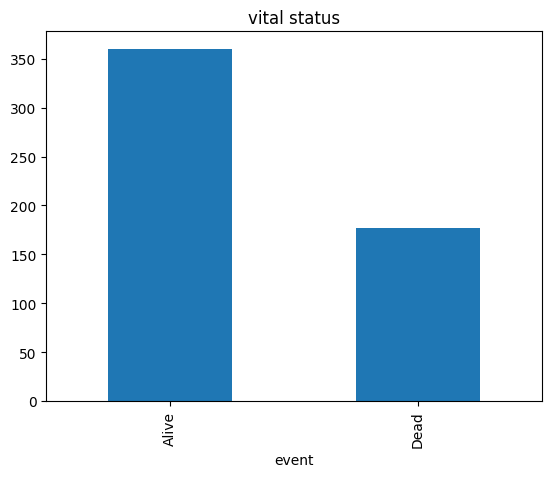

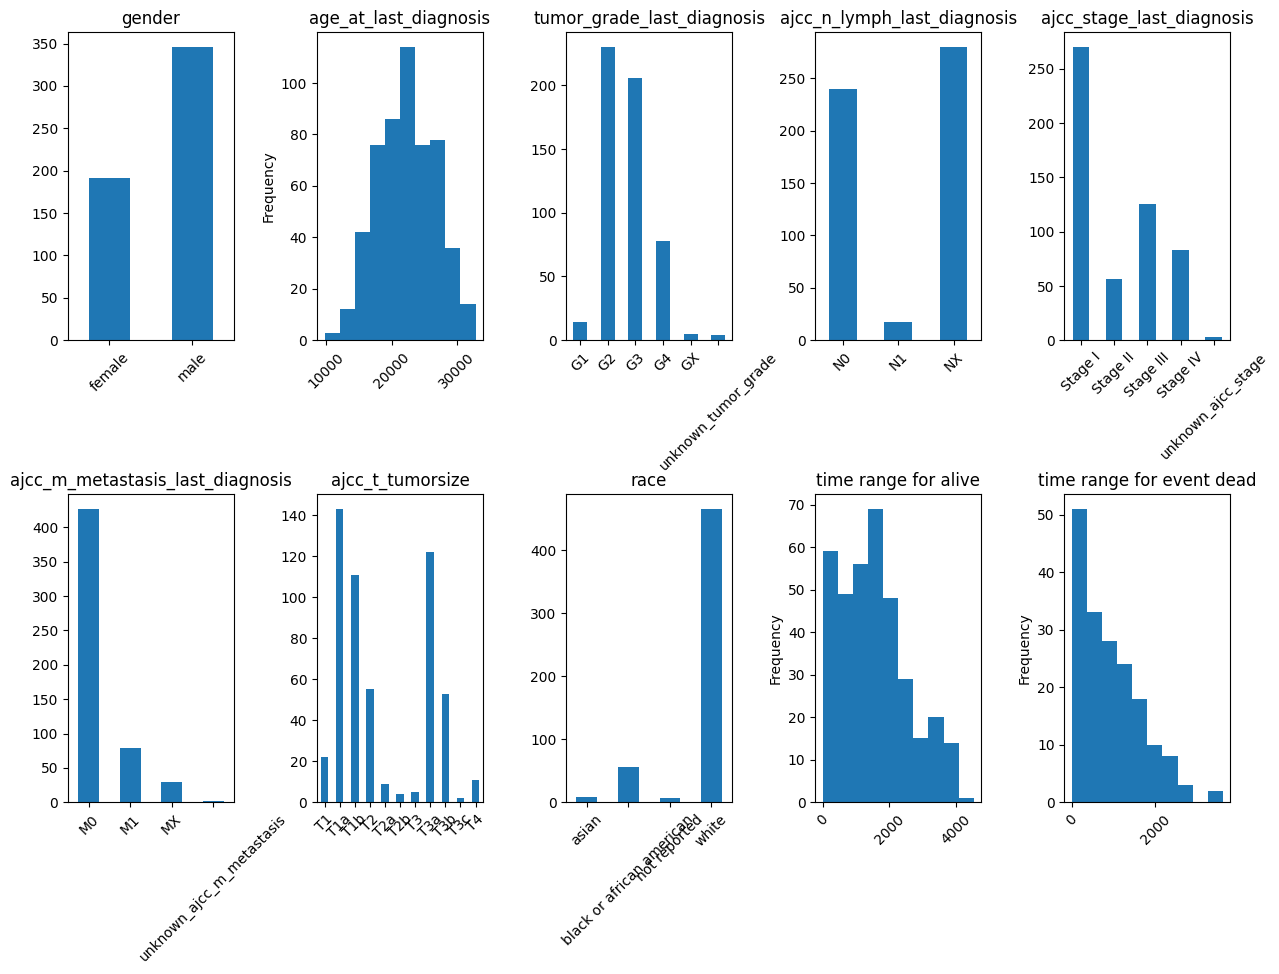

In [6]:
df = pd.read_csv(config["clinical"]["converted_to_clinical_json"])

df['event'].value_counts().sort_index().plot(kind='bar', title='vital status')

fig, axs = plt.subplots(2, 5, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

df['gender'].value_counts().sort_index().plot(kind='bar', ax=axs[0, 0], title='gender')
df['tumor_grade_last_diagnosis'].value_counts().sort_index().plot(kind='bar', ax=axs[0, 2], title='tumor_grade_last_diagnosis')
df['age_at_last_diagnosis'].plot(kind='hist', bins=10, ax=axs[0, 1], title='age_at_last_diagnosis')
df['ajcc_m_metastasis_last_diagnosis'].value_counts().sort_index().plot(kind='bar', ax=axs[1, 0], title='ajcc_m_metastasis_last_diagnosis')
df['ajcc_n_lymph_last_diagnosis'].value_counts().sort_index().plot(kind='bar', ax=axs[0, 3], title='ajcc_n_lymph_last_diagnosis')

df['ajcc_stage_last_diagnosis'].value_counts().sort_index().plot(kind='bar', ax=axs[0, 4], title='ajcc_stage_last_diagnosis')
df['ajcc_t_tumorsize_last_diagnosis'].value_counts().sort_index().plot(kind='bar', ax=axs[1, 1], title='ajcc_t_tumorsize')
df['race'].value_counts().sort_index().plot(kind='bar', ax=axs[1, 2], title='race')
df[df['event'] == "Alive"]['time'].plot(kind='hist', bins=10, ax=axs[1, 3], title='time range for alive')
df[df['event'] == "Dead"]['time'].plot(kind='hist', bins=10, ax=axs[1, 4], title='time range for event dead')

for ax in axs.flatten():
    ax.set_xlabel("")
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.show()

Features with imbalanced values:

- `ajcc_n_lymph_last_diagnosis`
- `race`
- `ajcc_m_metastasis_last_diagnosis`

We remove these because the model may overfit to the majority class of each of these features and the one-hot encoding features would be sparse (sparsity could lead to a waste in deep learning computation? need to recheck this) 

In [16]:
def cramers_v(var1, var2):
    """
    cramer's V two categorical variables
    https://datagy.io/cramers-v-python/
    """
    confusion_matrix = pd.crosstab(var1, var2)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

from itertools import combinations

check_collinearity_cats = ["ajcc_t_tumorsize_last_diagnosis", "ajcc_stage_last_diagnosis", "tumor_grade_last_diagnosis"]

for a, b in combinations(check_collinearity_cats, 2):
    print(f"{a} and {b}:")
    print(cramers_v(df[a], df[b]))  
  # moderately high correlation => include and let's see
    

ajcc_t_tumorsize_last_diagnosis and ajcc_stage_last_diagnosis:
0.7298100781131737
ajcc_t_tumorsize_last_diagnosis and tumor_grade_last_diagnosis:
0.2584556408665643
ajcc_stage_last_diagnosis and tumor_grade_last_diagnosis:
0.27179144106086384


In [ ]:
cleaned_df = pd.read_csv(config["clinical"]["cleaned_clinical_json"]).drop(["time", "event"], axis=1)

patient = cleaned_df.iloc[123]
case_id = patient["submitter_id"]
patient_clinical_features = list(patient.drop(["submitter_id"]))

torch.tensor(patient_clinical_features).unsqueeze(0).shape

torch.Size([1, 18])

In [ ]:
LABELS_DF = pd.read_csv(config["clinical"]["cleaned_clinical_json"])[["submitter_id", "event", "time"]]

labels_dict = {}
for submitter_id, event, time in zip(LABELS_DF["submitter_id"], LABELS_DF["event"], LABELS_DF["time"]):
    labels_dict[submitter_id] = {"event": event, "time": time}

labels_dict["TCGA-3Z-A93Z"]["time"]

385

# Fit model

"As a baseline against standard statistical approaches, we trained Cox Proportion Hazard Models using age, gender, and grade as covariates." (https://pmc.ncbi.nlm.nih.gov/articles/PMC10339462/#S11) 

# Check proportional hazard assumption

<lifelines.CoxPHFitter: fitted with 533 total observations, 358 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 533
number of events observed = 175
   partial log-likelihood = -922.26
         time fit was run = 2025-03-02 21:13:29 UTC

---
                                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                       
gender                                         -0.07      0.93      0.16           -0.38            0.24                0.68                1.27
age_at_last_diagnosis                           0.41      1.50      0.09            0.23            0.58                1.26                1.79
tumor_grade_last_diagnosis_G1                  -1.91      0.15      1.63           -5.10            1.28                0.01                3.61
tumor_grade_last_diagnosis_G2                  -0.19      0.82      0.55           -1.28            0.89                0.28                2.44
tumor_grade_last_diagnosis_G3                   0.15      1.16      0.55           -0.94            1.23                0.39                3.41
tumor_grade_last_diagnosis_G4                   0.60      1.82      0.56           -0.51            1.70                0.60                5.50
tumor_grade_last_diagnosis_GX                   0.07      1.07      1.12           -2.12            2.25                0.12                9.52
tumor_grade_last_diagnosis_unknown_tumor_grade -1.57      0.21      3.15           -7.74            4.60                0.00               99.86
ajcc_stage_last_diagnosis_Stage I              -0.51      0.60      0.55           -1.58            0.56                0.21                1.75
ajcc_stage_last_diagnosis_Stage II             -0.37      0.69      0.59           -1.52            0.78                0.22                2.18
ajcc_stage_last_diagnosis_Stage III             0.15      1.16      0.55           -0.93            1.22                0.40                3.40
ajcc_stage_last_diagnosis_Stage IV              0.98      2.68      0.55           -0.10            2.07                0.91                7.90
ajcc_stage_last_diagnosis_unknown_ajcc_stage    1.21      3.37      1.14           -1.02            3.45                0.36               31.57

                                                cmp to     z      p  -log2(p)
covariate                                                                    
gender                                            0.00 -0.47   0.64      0.64
age_at_last_diagnosis                             0.00  4.59 <0.005     17.75
tumor_grade_last_diagnosis_G1                     0.00 -1.17   0.24      2.05
tumor_grade_last_diagnosis_G2                     0.00 -0.35   0.73      0.46
tumor_grade_last_diagnosis_G3                     0.00  0.26   0.79      0.33
tumor_grade_last_diagnosis_G4                     0.00  1.06   0.29      1.80
tumor_grade_last_diagnosis_GX                     0.00  0.06   0.95      0.07
tumor_grade_last_diagnosis_unknown_tumor_grade    0.00 -0.50   0.62      0.69
ajcc_stage_last_diagnosis_Stage I                 0.00 -0.93   0.35      1.51
ajcc_stage_last_diagnosis_Stage II                0.00 -0.64   0.52      0.93
ajcc_stage_last_diagnosis_Stage III               0.00  0.27   0.79      0.35
ajcc_stage_last_diagnosis_Stage IV                0.00  1.78   0.07      3.75
ajcc_stage_last_diagnosis_unknown_ajcc_stage      0.00  1.06   0.29      1.80
---
Concordance = 0.77
Partial AIC = 1870.53
log-likelihood ratio test = 137.85 on 13 df
-log2(p) of ll-ratio test = 73.90


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.7687)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7935)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2750)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6428)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8186)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8029)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8900)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8684)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9551)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9999)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9861)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9444)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0596)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0758)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9408)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9488)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6782)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6381)'>],
 [<Axes: xlabel='rank-transformed tim

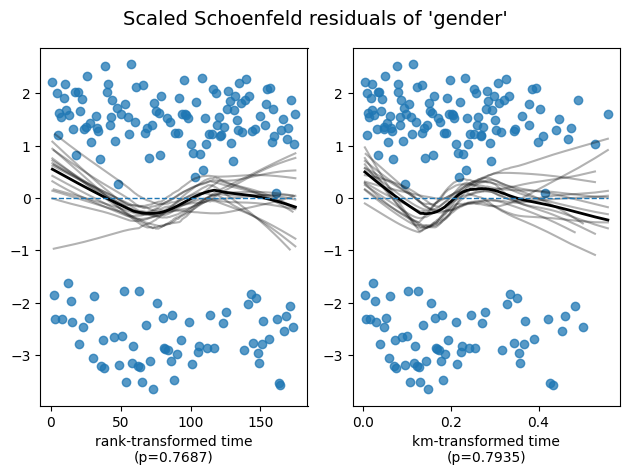

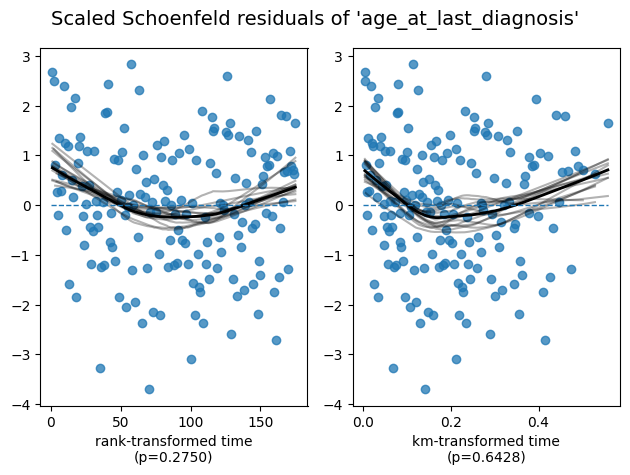

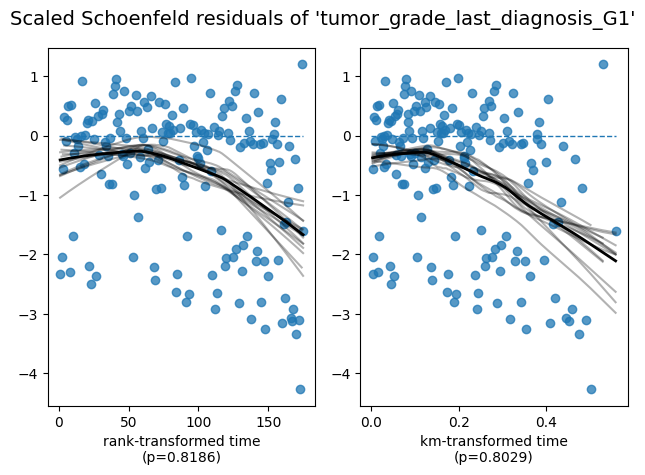

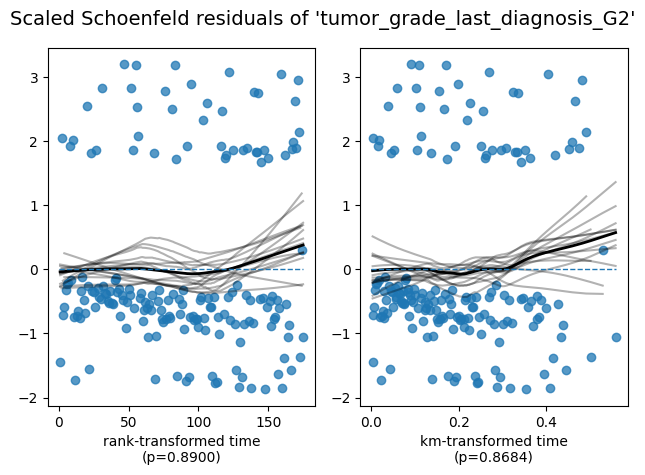

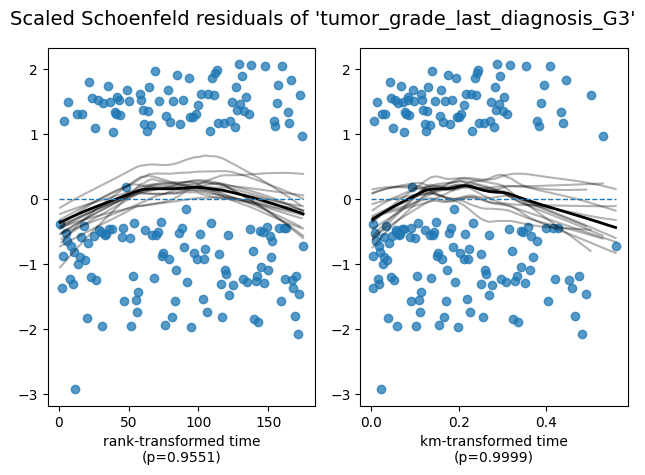

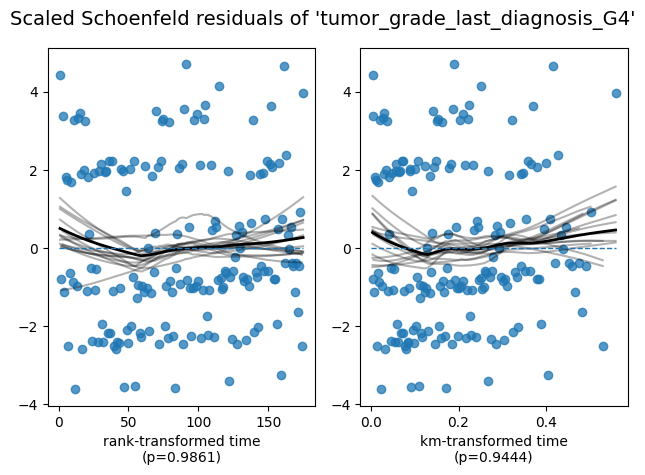

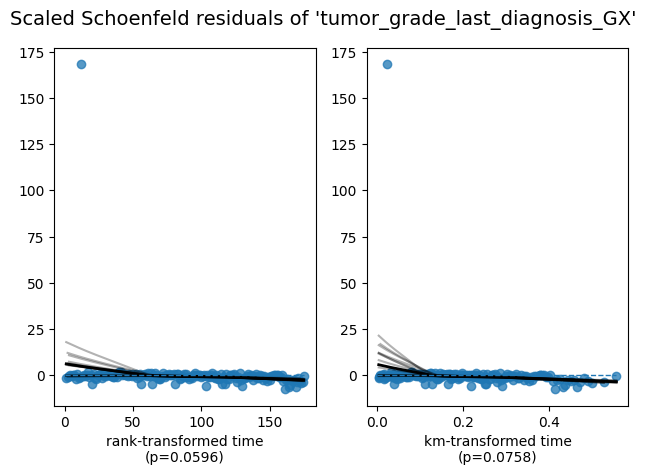

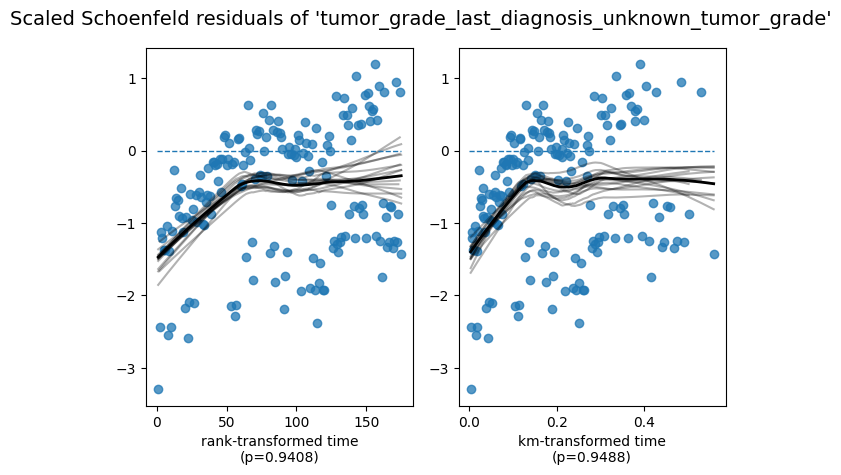

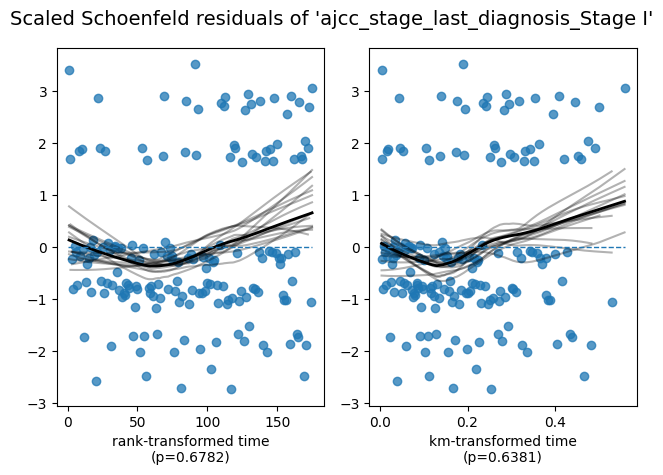

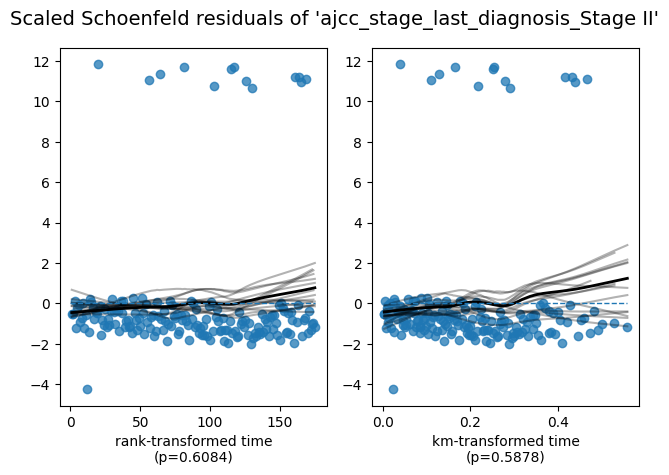

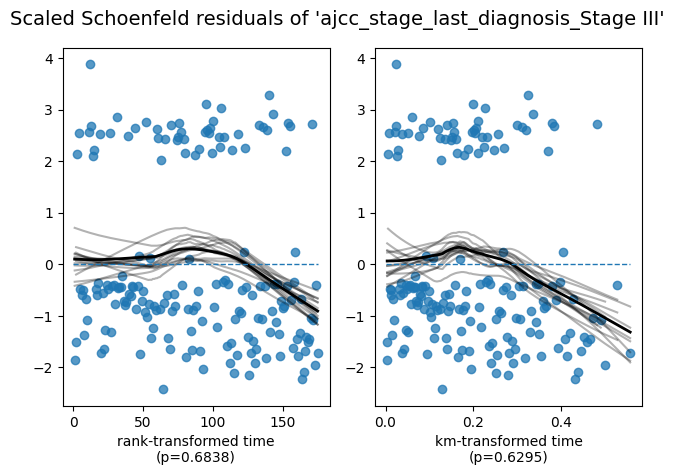

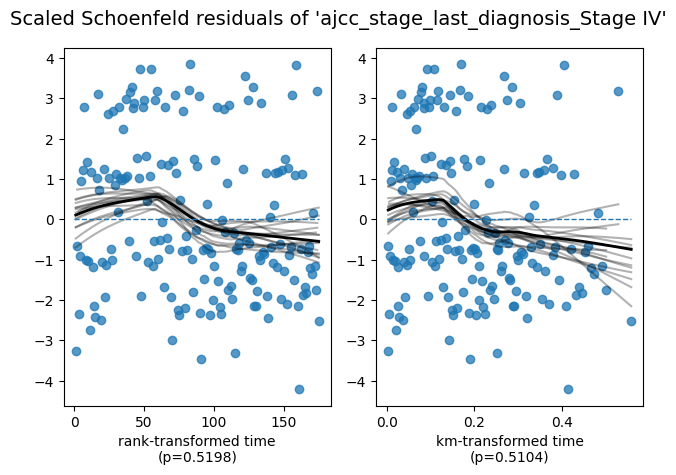

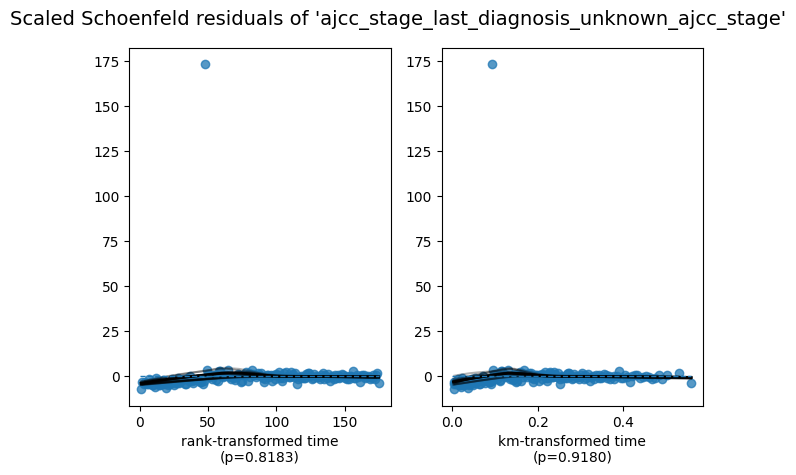

In [5]:
check_ph_assumption = pd.read_csv(config["clinical"]["cleaned_clinical_json"]).drop(["submitter_id"], axis=1)

cph = CoxPHFitter(penalizer=0.01)
cph.fit(check_ph_assumption, duration_col='time', event_col='event')
cph.print_summary()  

cph.check_assumptions(check_ph_assumption, p_value_threshold=0.05, show_plots=True)